Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'DESeq2', 'digest', 'edgeR', 'evaluate', 'GenomeInfoDb',
  'ggplot2', 'lifecycle', 'locfit', 'RcppArmadillo', 'rmarkdown', 'S4Arrays',
  'scales', 'SparseArray', 'tidyselect', 'xfun'



In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [4]:
setwd("../paired.TAM.AMLv2/")


In [5]:
getwd()


[1] "/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2"

In [6]:
cts <- as.matrix(read.csv("RI.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [7]:
cts[1:3,11:dim(cts)[2]]

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,16,30,6,0,26,38,7,44,17,31
2,3,10,0,0,17,11,11,13,17,13
3,0,0,0,0,5,0,0,8,0,0


In [8]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,riexonStart_0base,riexonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761,chr1,+,100078450,100080659,100078450,100078548,100080495,100080659
2,ENSG00000122435.11,TRMT13,chr1,+,100140407,100141019,100140407,100140514,100140851,100141019
3,ENSG00000233184.8,ENSG00000233184,chr1,+,101080388,101083574,101080388,101080613,101083460,101083574


In [9]:
featureData <- featureData[,c(1,2)]

In [10]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761
2,ENSG00000122435.11,TRMT13


In [11]:
cts <- data.matrix(cts[,11:20])


In [12]:
dim(cts)
head(cts,2)

[1] 7301   10

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,16,30,6,0,26,38,7,44,17,31
2,3,10,0,0,17,11,11,13,17,13


In [13]:
colnames(cts) <- c("PAUVKY.03A","PAUVKY.40A","PAWHSD.03A","PAWHSD.40A","PAWSNZ.03A","PAWSNZ.40A","PAUTLA.03A","PAUTLA.40A","PAVUDU.03A","PAVUDU.40A")

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.

In [14]:
cts <- cts[,-c(3,4)]

In [15]:
dim(cts)
head(cts,4)
mode(cts) <- "integer"
is.integer(cts)

[1] 7301    8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,16,30,26,38,7,44,17,31
2,3,10,17,11,11,13,17,13
3,0,0,5,0,0,8,0,0
4,0,0,0,0,0,12,0,0


[1] TRUE

In [16]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,16,30,26,38,7,44,17,31
2,3,10,17,11,11,13,17,13


In [17]:
# Condition 1: Rows with count > 1000 in columns 1, 3, 5, 7
TAM_rows_condition <- rowSums(cts[, c(1, 3, 5, 7)] > 100) > 0
TAM_matrix<- cts[TAM_rows_condition, c(1, 3, 5, 7)]

# Condition 2: Rows with count > 1000 in columns 2, 4, 6, 8
AML_rows_condition <- rowSums(cts[, c(2, 4, 6, 8)] > 100) > 0
AML_matrix <- cts[AML_rows_condition, c(2, 4, 6, 8)]

# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
final_matrix <- cts[AML_rows_condition | TAM_rows_condition, ]

# View the dimensions of the resulting matrices
dim(TAM_matrix)
dim(AML_matrix)
dim(final_matrix)


[1] 2015    4

[1] 1531    4

[1] 2113    8

In [18]:
featureData <- featureData[rownames(cts),]
head(featureData)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000283761.1,ENSG00000283761
2,ENSG00000122435.11,TRMT13
3,ENSG00000233184.8,ENSG00000233184
4,ENSG00000233184.8,ENSG00000233184
5,ENSG00000185946.16,RNPC3
6,ENSG00000134186.12,PRPF38B


In [24]:
featureData[featureData[,"geneSymbol"] == "B2M",]
cts[rownames(featureData[featureData[,"geneSymbol"] == "B2M",]),]

,GeneID,geneSymbol
,<chr>,<chr>
2297,ENSG00000166710.22,B2M
2298,ENSG00000166710.22,B2M


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
2297,362,340,709,490,299,535,214,557
2298,14105,11421,25564,14792,10404,18411,10450,26156


In [27]:
featureData[featureData[,"geneSymbol"] == "ACTG1",]
cts[rownames(featureData[featureData[,"geneSymbol"] == "ACTG1",]),]

,GeneID,geneSymbol
,<chr>,<chr>
3443,ENSG00000184009.13,ACTG1
3444,ENSG00000184009.13,ACTG1
3445,ENSG00000184009.13,ACTG1
3446,ENSG00000184009.13,ACTG1
3447,ENSG00000184009.13,ACTG1
3448,ENSG00000184009.13,ACTG1
3449,ENSG00000184009.13,ACTG1


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
3443,7024,3375,5899,2483,8924,3109,6864,13766
3444,6103,2903,5400,2113,7916,2682,6237,11481
3445,63,7,67,44,75,37,53,50
3446,78,15,98,63,101,40,62,69
3447,2394,841,2293,625,3057,712,2588,3050
3448,64,14,61,52,79,38,68,42
3449,43,0,55,40,57,31,60,30


In [28]:
head(TAM_matrix)
head(AML_matrix)
head(final_matrix)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
6,143,212,123,195
9,81,127,38,45
13,167,188,83,106
14,100,142,48,74
15,107,153,50,80
16,106,155,51,58


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
6,208,170,288,238
13,55,72,68,105
23,271,19,368,51
25,337,249,314,431
38,106,120,124,112
54,122,99,133,122


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
6,143,208,212,170,123,288,195,238
9,81,25,127,37,38,37,45,59
13,167,55,188,72,83,68,106,105
14,100,37,142,52,48,45,74,55
15,107,40,153,52,50,45,80,58
16,106,32,155,52,51,53,58,59


In [29]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [30]:
dim(cts)
dim(featureData)

[1] 2113    8

[1] 2113    2

In [31]:
coldata <- read.csv("design_matrix.csv",row.names=1)

In [32]:
coldata


,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,TAM
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,TAM
PAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,TAM
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,TAM
PAVUDU-40A,PAVUDU,AML


In [33]:
coldata <- coldata[,c("patient","condition")]
coldata$condition <- factor(coldata$condition)
coldata$patient <- factor(coldata$patient)

In [34]:
rownames(coldata)

[1] "PAUVKY-03A" "PAUVKY-40A" "PAWSNZ-03A" "PAWSNZ-40A" "PAUTLA-03A"
[6] "PAUTLA-40A" "PAVUDU-03A" "PAVUDU-40A"

In [35]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [36]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [37]:
all(rownames(coldata) %in% colnames(cts))

[1] TRUE

In [38]:
# lets look at limma/voom
BiocManager::install("limma")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'DESeq2', 'digest', 'edgeR', 'evaluate', 'GenomeInfoDb',
  'ggplot2', 'lifecycle', 'locfit', 'RcppArmadillo', 'rmarkdown', 'S4Arrays',
  'scales', 'SparseArray', 'tidyselect', 'xfun'



In [39]:
BiocManager::install("statmod")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'statmod'”
Old packages: 'DESeq2', 'digest', 'edgeR', 'evaluate', 'GenomeInfoDb',
  'ggplot2', 'lifecycle', 'locfit', 'RcppArmadillo', 'rmarkdown', 'S4Arrays',
  'scales', 'SparseArray', 'tidyselect', 'xfun'



In [40]:
library(limma)
library(edgeR)
library(statmod)

In [41]:
# making a counts matrix
dge <- DGEList(counts=cts)

In [42]:
colnames(dge)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [43]:
head(dge,2)

An object of class "DGEList"
$counts
  PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A PAVUDU.03A
6        143        208        212        170        123        288        195
9         81         25        127         37         38         37         45
  PAVUDU.40A
6        238
9         59

$samples
           group lib.size norm.factors
PAUVKY.03A     1   463042            1
PAUVKY.40A     1   385979            1
PAWSNZ.03A     1   659838            1
PAWSNZ.40A     1   343649            1
PAUTLA.03A     1   585106            1
PAUTLA.40A     1   439190            1
PAVUDU.03A     1   474890            1
PAVUDU.40A     1   514258            1

In [44]:
design <- model.matrix(~ 0 + factor(c(1,2,1,2,1,2,1,2)))
colnames(design) <- c("TAM","AML")

In [45]:
design

,TAM,AML
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [46]:
# normalize and filter
keep          <-filterByExpr(dge, design)

In [47]:
is.logical(keep)
sum(keep==TRUE)

[1] TRUE

[1] 2055

In [48]:
dge          <- dge         [keep,,keep.lib.size=FALSE]

In [49]:
# apply scale normalization
dge          <- calcNormFactors(dge)

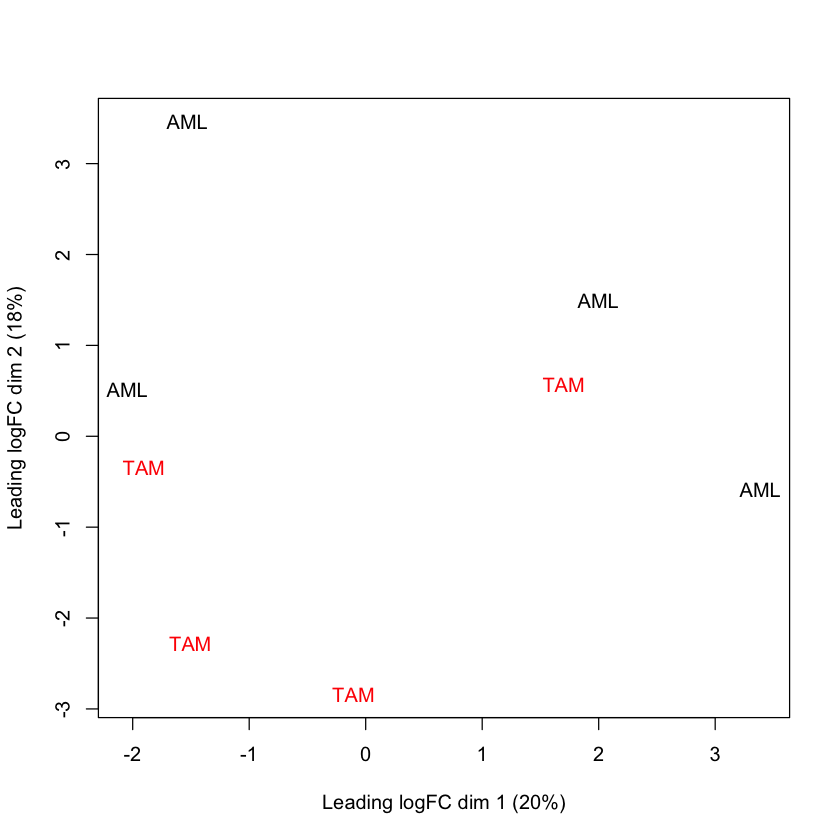

In [50]:
# MDS Plot - can we separate the samples well?
logCPM <- cpm(dge, log=TRUE, prior.count=3)
plotMDS(logCPM,labels=coldata$condition,top=10, col=c(rep(c("red","black"),3)))

In [51]:
head(logCPM)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
6,8.334174,9.031991,8.313602,8.846277,7.921949,9.255965,8.787064,9.041617
9,7.535548,6.097199,7.593359,6.715627,6.308839,6.392961,6.738584,7.080836
13,8.553955,7.160415,8.143912,7.633440,7.372421,7.220809,7.924825,7.882725
14,7.830217,6.619088,7.749441,7.181452,6.621792,6.656006,7.422441,6.984427
15,7.925213,6.724612,7.854043,7.181452,6.676989,6.656006,7.530937,7.057331
16,7.912019,6.424008,7.872272,7.181452,6.703816,6.878406,7.085509,7.080836


In [52]:
head(dge,2)

An object of class "DGEList"
$counts
  PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A PAVUDU.03A
6        143        208        212        170        123        288        195
9         81         25        127         37         38         37         45
  PAVUDU.40A
6        238
9         59

$samples
           group lib.size norm.factors
PAUVKY.03A     1   458755    0.9850859
PAUVKY.40A     1   385384    1.0435703
PAWSNZ.03A     1   656452    1.0355445
PAWSNZ.40A     1   340121    1.1010329
PAUTLA.03A     1   572156    0.9100614
PAUTLA.40A     1   436310    1.0908541
PAVUDU.03A     1   468298    0.9562568
PAVUDU.40A     1   508596    0.8987175

In [53]:
fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)
de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 2055

[1] "RPL13"  "ADAR"   "RPS11"  "ADAR"   "PABPC1" "PABPC1"

In [54]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 5
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 2037    6

In [55]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 2037    8

[1] 2037

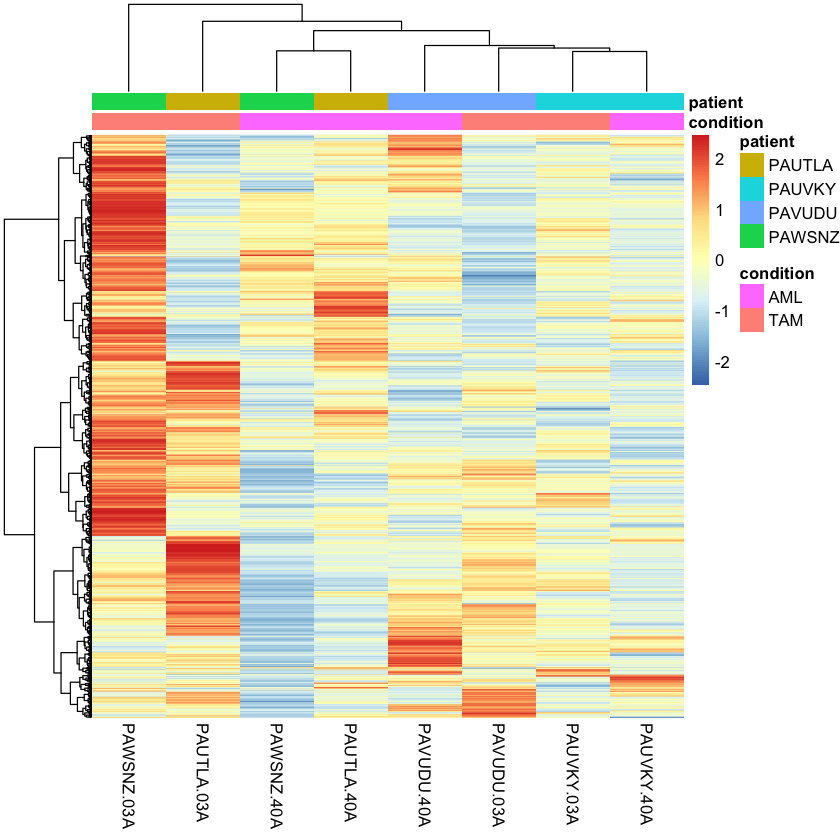

In [56]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

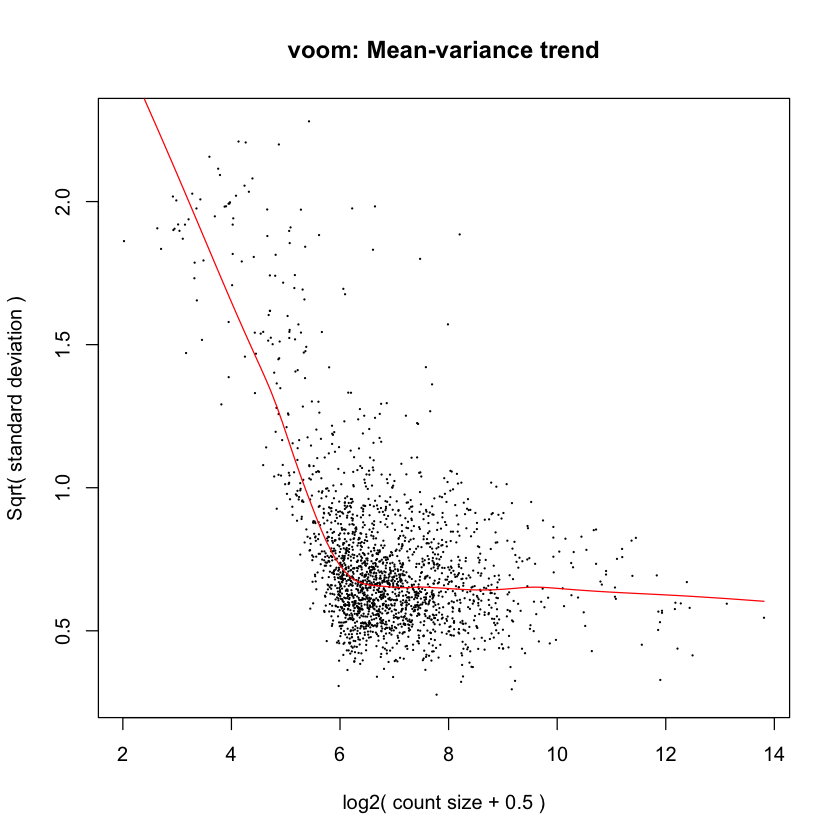

In [57]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [58]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 2055

[1] "RPL8"   "RPS23"  "B2M"    "RPL18A" "RPS11"  "PABPC1"

In [59]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 353   6

In [60]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

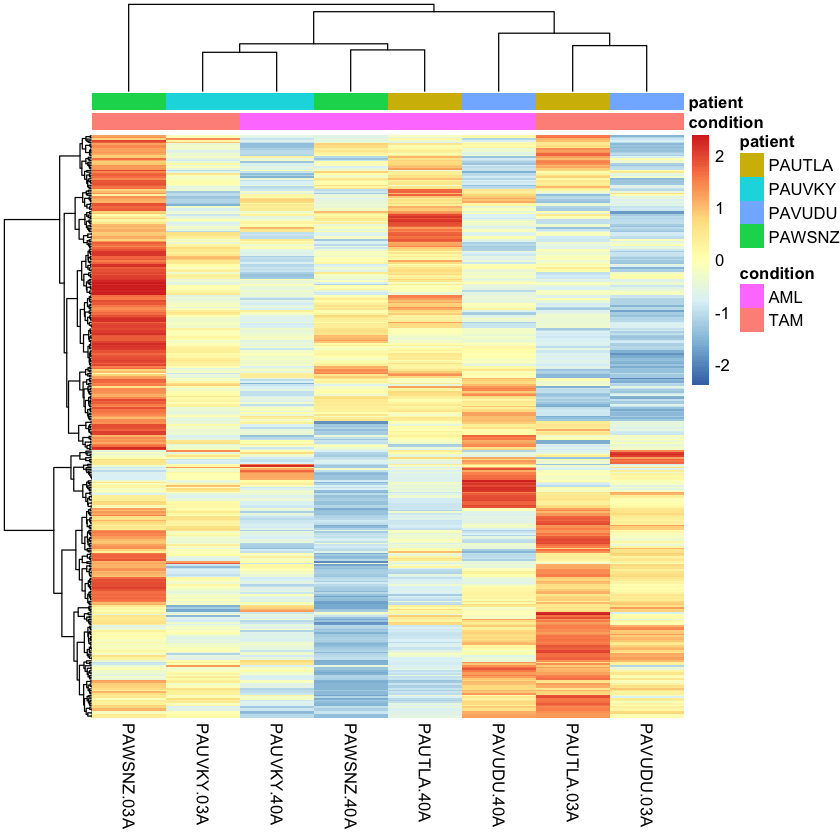

In [61]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [62]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(significant_out, "2024Mar12_RI_voom_9fold_top_significant_genes.pdf")

pdf 
  2

In [63]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPL8"   "RPS23"  "B2M"    "RPL18A" "RPS11"

In [64]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 353

In [65]:
top_significant_genes <- dge[rownames(significant_genes),]

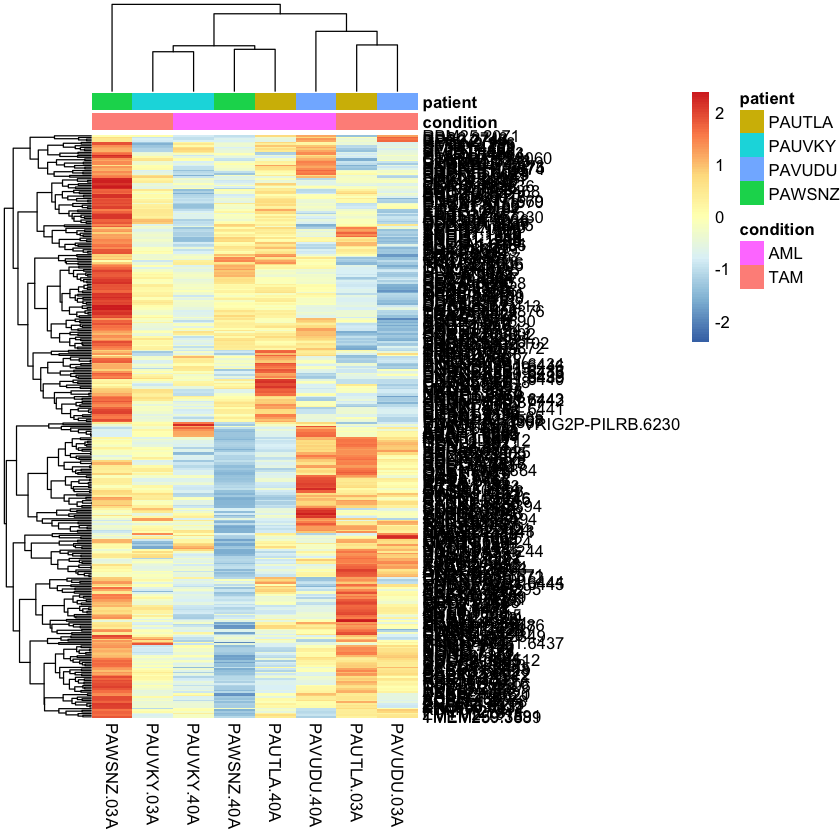

In [66]:
start=1
stop=length(top_gene_list)
date="2024Mar12_RI_voom"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [67]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, "2024Mar12_voom_piece_9fold_top_significant_genes.pdf")

pdf 
  2

In [68]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 353   2

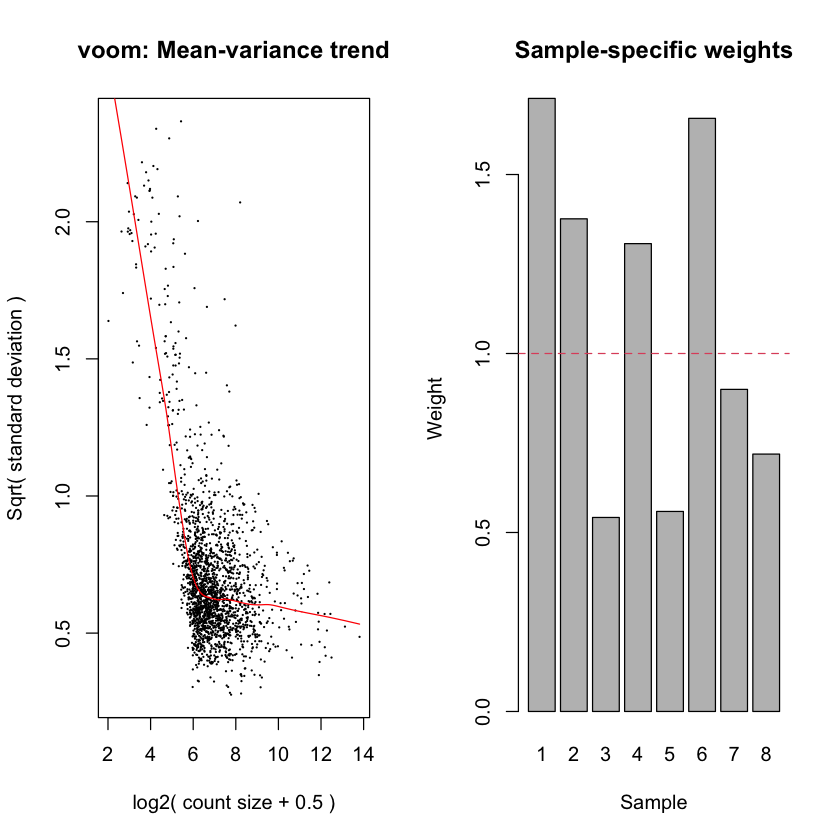

In [69]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [70]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [71]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 2055

[1] "B2M"    "RPL8"   "RPS23"  "PABPC1" "RPL18A" "RPL13"

In [72]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 356   6

In [73]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

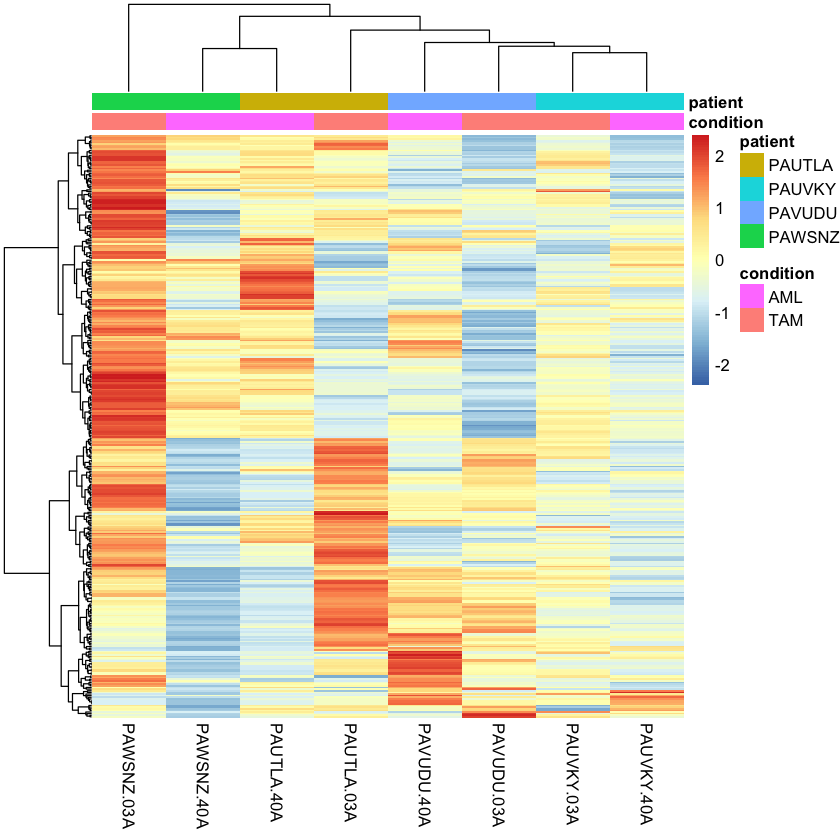

In [74]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [75]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(significant_out, "2024Mar12_vwts_9fold_top_significant_genes.pdf")

pdf 
  2

In [76]:
featureData[head(rownames(significant_expression),5),2]

[1] "B2M"    "RPL8"   "RPS23"  "PABPC1" "RPL18A"

In [77]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 356

In [78]:
top_significant_genes <- dge[rownames(significant_genes),]

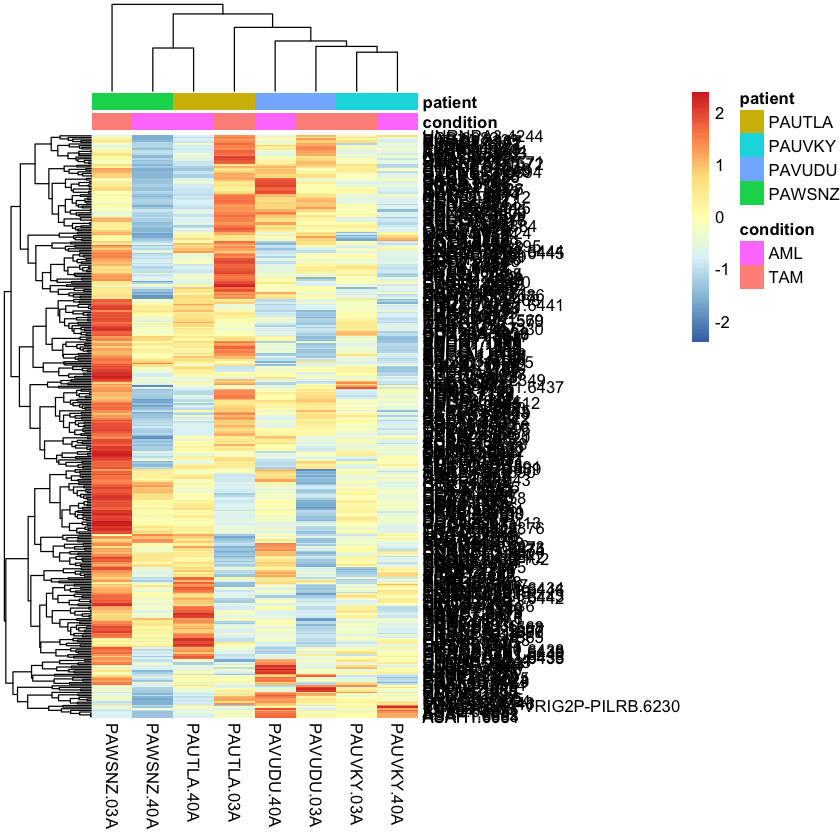

In [79]:
start=1
stop=length(top_gene_list)
date="2024Mar12_RI_vwts"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [80]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, "2024Mar12_vwts_piece_9fold_top_significant_genes.pdf")

pdf 
  2

In [81]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 356   2